# Lab 07: Credit Card Fraud Detection

---
author: Brady Brooks
date: October 25, 2024
embed-resources: true
---

## Introduction

In this report, I create a model to predict whether or not a card transaction is fradulent. Everyday millions if not billions of card transactions occur. The model I have created is a random forest decision tree to classify whether or not a transaction is fradulent. Given the information at the time of a transaction such as time, location, amount, etc, the model will classify the transaction. 

## Methods

In [2]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, fbeta_score, make_scorer
import warnings

### Data

In [3]:
# load data
fraud = pd.read_parquet("https://cs307.org/lab-07/data/fraud.parquet")
fraud_train, fraud_test = train_test_split(
    fraud,
    test_size=0.20,
    random_state=42,
    stratify=fraud["Fraud"],
)
fraud_train

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
57638,-0.514509,0.899378,1.627215,-0.142250,0.005250,-0.235422,0.482540,0.247403,-0.562327,-0.166813,...,-0.143290,-0.390205,0.030719,0.184779,-0.348711,0.073253,0.273217,0.107938,3.59,0
27686,-0.813568,-0.373893,1.152977,-0.449774,-3.868866,2.780636,3.654192,-0.672442,0.753230,-0.662803,...,-0.376783,-0.004239,0.074801,0.124238,-0.448493,0.861423,-0.093639,-0.711632,798.01,0
13321,-2.443142,3.258831,-0.791511,0.223548,0.007932,-1.263044,1.220214,-0.418068,1.860453,4.184883,...,-0.348587,0.531679,0.058990,0.371638,-0.207398,-0.505837,0.524542,-0.343895,1.79,0
28308,-0.397300,0.922104,1.224699,-0.334974,0.322603,-0.117372,0.534683,0.175550,-0.486404,-0.120147,...,-0.239303,-0.695001,-0.128231,-0.536463,-0.138971,0.107526,0.255644,0.100814,2.69,0
54252,1.994046,-0.367813,-0.462867,0.338661,-0.485326,-0.241576,-0.590987,0.089319,1.413224,-0.149292,...,-0.196388,-0.484457,0.421867,0.601393,-0.448014,-0.646256,0.027632,-0.027244,4.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49499,-0.033583,-0.487672,1.435406,-2.759369,-1.785638,0.402364,-2.306038,-2.287179,0.129717,-1.036412,...,-1.286823,0.824100,0.018890,0.000018,0.301618,0.081215,0.163422,0.252456,10.00,0
29250,-0.731245,1.151677,0.912393,-0.653540,0.700577,-0.461372,1.093273,-0.126254,-0.339171,-0.467356,...,-0.368185,-0.991854,-0.376461,-0.661608,0.554237,0.450650,0.076395,0.096252,6.99,0
31586,2.135923,-0.714182,-1.842502,-0.587267,0.090754,-0.465733,-0.024834,-0.328747,-0.659832,0.853241,...,-0.537267,-1.081138,0.196589,0.087797,-0.111583,0.479888,-0.082523,-0.053305,64.90,0
14898,-0.335632,0.939736,-2.961515,-1.224739,4.446891,2.352092,0.789725,0.609460,-0.746845,-1.580751,...,-0.002116,0.009686,-0.428325,0.536043,0.278736,0.680976,-0.069295,0.051891,0.76,0


The data was collected from Kaggle. Each observation is a credit card transaction with features about the transaction and whether or not it was fraudulent. Some genuine transactions have been removed to reduce the size of the data.

##### Response

Fraud
-   [int64] status of the transaction. (1 indicating a fradulent transaction, 0 indicatng a genuine transaction)


##### Features

Amount
-   [float64] amount (in dollars) of the transaction

PC01 - PC28
-   [float64] the 28 principal components the encode information such as location and type of purchase while preserving customer privacy

In [4]:
# summary statistics
print("Samples & Features: ", fraud_train.shape)
print("Count of Not Fraudulent Samples: ", len(fraud_train[fraud_train.Fraud == 0]))
print("Count of Fraudulent Samples: ", len(fraud_train[fraud_train.Fraud == 1]))

Samples & Features:  (54276, 30)
Count of Not Fraudulent Samples:  53961
Count of Fraudulent Samples:  315


Notice that over 99% of the transactions are genuine transactions.

In [5]:
display("No Condition:", fraud_train["Amount"].describe().loc[["mean", "std", "50%", "max"]])
display("Not Fraud:", fraud_train[fraud_train.Fraud == 0]["Amount"].describe().loc[["mean", "std", "50%", "max"]])
display("Fraud:", fraud_train[fraud_train.Fraud == 1]["Amount"].describe().loc[["mean", "std", "50%", "max"]])

'No Condition:'

mean       88.197903
std       241.535617
50%        21.690000
max     10199.440000
Name: Amount, dtype: float64

'Not Fraud:'

mean       88.065104
std       241.451144
50%        21.800000
max     10199.440000
Name: Amount, dtype: float64

'Fraud:'

mean     110.947016
std      254.978960
50%        6.990000
max     2125.870000
Name: Amount, dtype: float64

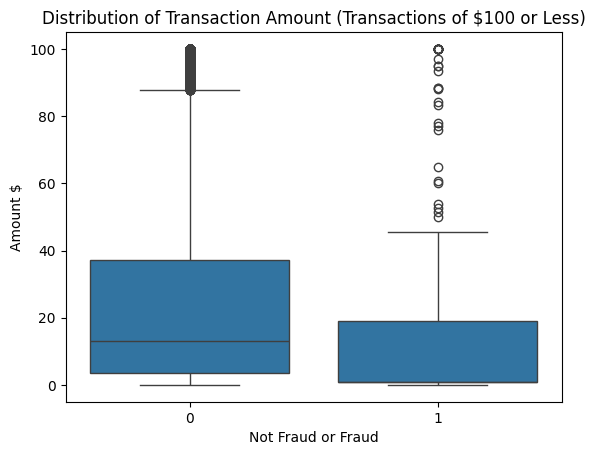

In [6]:
# visualizations
fraud100 = fraud_train[fraud_train.Amount <= 100]
fraud101 = fraud_train[fraud_train.Amount > 100]
sns.boxplot(data=fraud100, x='Fraud', y='Amount')
plt.title("Distribution of Transaction Amount (Transactions of $100 or Less)")
plt.xlabel("Not Fraud or Fraud")
plt.ylabel("Amount $")
plt.show()

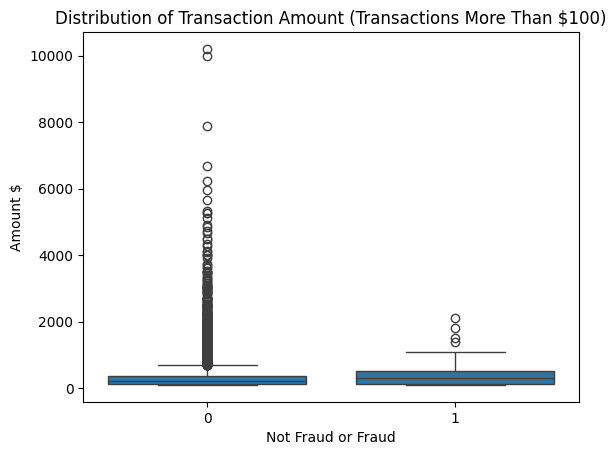

In [7]:
sns.boxplot(data=fraud101, x='Fraud', y='Amount')
plt.title("Distribution of Transaction Amount (Transactions More Than $100)")
plt.xlabel("Not Fraud or Fraud")
plt.ylabel("Amount $")
plt.show()

We can see that a majoriy of the transactions over $1000 were genuine transactions. Most of the fradulent transactions were actually pretty low in cost compared to the genuine ones. 

### Models

In [8]:
# process data for ML
# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

To develop a model, I tuned a Random Forest Classifier. To tune the model I tuned numerous parameters such as n_estimators, maximum depth of the tree, maximum features used to classify, and the class weight. All the features used in this model are numeric. To preprossess the data, I imputed the mean for any missing values and implemented a standard scaler. 

The model was tuned using a grid search where the models were compared based on their F-1 score.

In [9]:
# train models
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
# pipeline for numeric
numeric_preprocessor = Pipeline(steps=[
    ("MedianImputer", SimpleImputer(strategy="mean")), 
    ("Standardize", StandardScaler()),
    ])
# column transformer 
preprocessor = ColumnTransformer([
    ("NumericProcessing", numeric_preprocessor, numeric_features),
])
# full pipeline
pipeline = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Classifier", RandomForestClassifier())
])

In [10]:
param_grid = [ 
    {"Classifier": [RandomForestClassifier()],
        "Classifier__n_estimators": [50, 100],
        "Classifier__max_depth": [None, 4, 5, 6, 10],
        "Classifier__max_features": ["sqrt"],
        "Classifier__class_weight": [{0:1,1:3},"balanced"],
    }
]

In [11]:
warnings.filterwarnings("ignore")
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "f1": make_scorer(fbeta_score, beta=1)}
mod = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit="f1")
_ = mod.fit(X_train, y_train)

## Results

In [12]:
# helper function to print cross-validation results
def print_metric_scores(grid, metric):
    cv_results = grid.cv_results_
    best_index = grid.best_index_
    mean_score = cv_results[f"mean_test_{metric}"][best_index]
    std_score = cv_results[f"std_test_{metric}"][best_index]
    print(f"CV {metric} (mean ± std): {mean_score:.3f} ± {std_score:.3f}")

In [13]:
# report model metrics
mod.best_params_

{'Classifier': RandomForestClassifier(),
 'Classifier__class_weight': 'balanced',
 'Classifier__max_depth': 10,
 'Classifier__max_features': 'sqrt',
 'Classifier__n_estimators': 50}

Of the models considered, the Random Forest Classifier with the greatest F1 score was the model with a balanced class weight, maximum depth of 10, maximum features of the square root of all features, and a n_estimator of 50. 

In [14]:
print_metric_scores(mod, "accuracy")
print_metric_scores(mod, "precision")
print_metric_scores(mod, "recall")
print_metric_scores(mod, "f1")

CV accuracy (mean ± std): 0.999 ± 0.000
CV precision (mean ± std): 0.949 ± 0.025
CV recall (mean ± std): 0.810 ± 0.033
CV f1 (mean ± std): 0.873 ± 0.018


In [15]:
# calculate test metrics
y_pred = mod.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = fbeta_score(y_test, y_pred, beta=1)

# print test metrics
print("")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


Test Accuracy: 0.998673446827327
Test Precision: 0.9841269841269841
Test Recall: 0.7848101265822784
Test F1 Score: 0.8732394366197183


The Random Forest Classifier achieved a test F1 Score of 0.8732394366197183, Accuracy of 0.998673446827327, Precision Score of 0.9841269841269841, and a Recall Score of 0.7848101265822784.

## Discussion

I first note that the model was very accurate but this was mainly due to the fact that almost all of the transactions were genuine. Looking at the other metrics such as percision, we can see that of all the transactions that were classified as fraudulent, almost all of them were. However, looking at the model's recall scsore, we can see that the model was able to predict under 80% of the fraudulent correctly. When it comes to the importance of precision and recall, in this senario, recall is much more important as we need the model to correctly predict all of the fraudulent transactions so we take action. Any genuine transaction accidentily classified as fraud would simply just be an inconvience. Any fraudulent transaction accidently classified as genuine could have massive consequences. 

### Conclusion

At this moment, I would not use this model in practice as I do not belive it predicts enough of the fradulent transactions correctly. The model could be improved by testing other classifiers and tuning other parameters. It is crucial to detect fraudulent transactions and at this time I do not believe this model is sufficient enough in doing just that.

In [16]:
from joblib import dump
dump(mod, "credit-fraud.joblib")

'from joblib import dump\ndump(mod, "credit-fraud.joblib")'